# Retention Time Prediction


This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/). In order to train the model faster, please change the runtime of Colab to use Hardware Accelerator, either GPU or TPU.

This notebook presents a short analysis of the learning rate task where we  train the model with different learning rate and analyze the results and how does the training rate affects the model.

In [ ]:
# install the dlpro package in the current environment using pip

!python -m pip install -q git+https://github.com/wilhelm-lab/dlomix.git

The available modules in the framework are as follows:

In [ ]:
import numpy as np
import pandas as pd
import dlomix

## 1. Load Data

In [ ]:
from dlomix.data.RetentionTimeDataset import RetentionTimeDataset

In [ ]:
TRAIN_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_train_val.csv'
BATCH_SIZE = 64

rtdata = RetentionTimeDataset(data_source=TRAIN_DATAPATH,
                              seq_length=30, batch_size=BATCH_SIZE, val_ratio=0.2, test=False)

Now we have an RT dataset that can be used directly with standard or custom `Keras` models. This wrapper contains the splits we chose when creating it. In our case, they are training and validation splits. To get the TF Dataset, we call the attributes `.train_data` and `.val_data`.

In [ ]:
len(rtdata.train_data)

424

In [ ]:
len(rtdata.val_data)

106

## 2. Training

### Learning Rate
Similar to the initial notebook we will initialize our model and train it.
Use train_model method with different learning rates and check which learning rate would be the best to work with our dataset.

In [ ]:
from dlomix.models.base import RetentionTimePredictor
import tensorflow as tf
from dlomix.eval.rt_eval import TimeDeltaMetric

In [ ]:
def train_model(learning_rate):
  model = RetentionTimePredictor(seq_length=30)
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,decay=1e-7)

  # compile the model  with the optimizer and the metrics we want to use, we can add our customer delta95 metric

  model.compile(optimizer=optimizer, 
                loss='mse',
                metrics=['mean_absolute_error', TimeDeltaMetric(rtdata.data_mean, rtdata.data_std)])
  history = model.fit(rtdata.train_data,
                    validation_data=rtdata.val_data,
                    epochs=15)
  return history

Here we try different learning rate between 0.0001 and 0.1 and see how our losses converge.

In [ ]:
histories = []
for learning_rate in (10**i for i in range(-4,0)):
  print(learning_rate)
  histories.append(train_model(learning_rate))

0.0001
Epoch 1/15
424/424 [==============================] - 40s 18ms/step - loss: 1976.1377 - mean_absolute_error: 34.2652 - timedelta: 35.9896 - val_loss: 509.1171 - val_mean_absolute_error: 18.2189 - val_timedelta: 16.3341
Epoch 2/15
424/424 [==============================] - 8s 18ms/step - loss: 335.5058 - mean_absolute_error: 14.2797 - timedelta: 15.1515 - val_loss: 240.7201 - val_mean_absolute_error: 11.8238 - val_timedelta: 10.9882
Epoch 3/15
424/424 [==============================] - 7s 17ms/step - loss: 201.4107 - mean_absolute_error: 10.6984 - timedelta: 11.6331 - val_loss: 175.1670 - val_mean_absolute_error: 9.7686 - val_timedelta: 9.1176
Epoch 4/15
424/424 [==============================] - 7s 18ms/step - loss: 165.3759 - mean_absolute_error: 9.5550 - timedelta: 10.4391 - val_loss: 158.1387 - val_mean_absolute_error: 9.2003 - val_timedelta: 8.4322
Epoch 5/15
424/424 [==============================] - 8s 18ms/step - loss: 152.8183 - mean_absolute_error: 9.1211 - timedelta: 9

## 3. Analysis

After Training 4 models with different learning rates we will analyze it to figure out which was the best learning rate to use for our problem.

In [ ]:
from dlomix.reports.RetentionTimeReport import RetentionTimeReport

#### Learning Rate = 0.0001

In [ ]:
report = RetentionTimeReport(output_path="./output", history=histories[0])

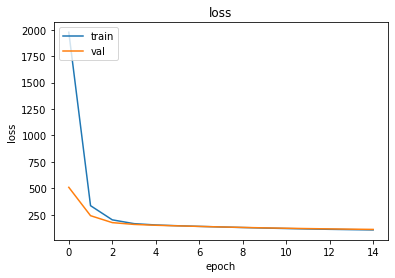

In [ ]:
report.plot_keras_metric("loss")

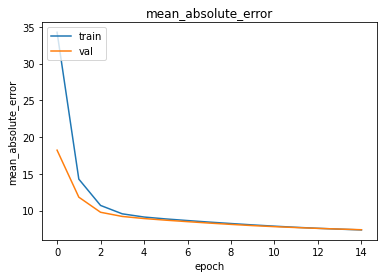

In [ ]:
report.plot_keras_metric("mean_absolute_error")

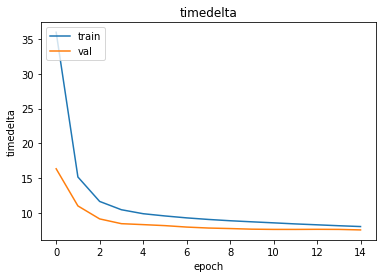

In [ ]:
report.plot_keras_metric("timedelta")

#### Learning Rate = 0.001

In [ ]:
report = RetentionTimeReport(output_path="./output", history=histories[0])

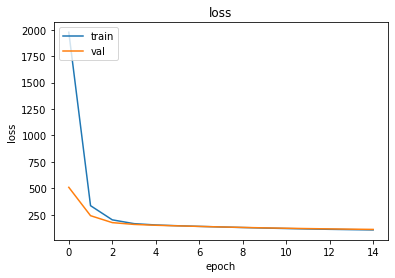

In [ ]:
report.plot_keras_metric("loss")

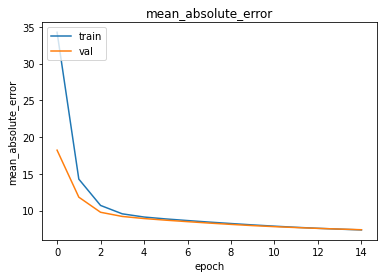

In [ ]:
report.plot_keras_metric("mean_absolute_error")

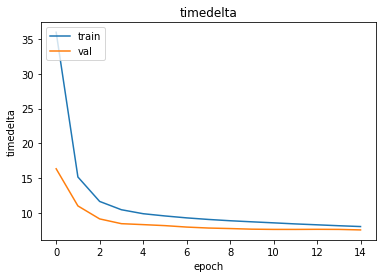

In [ ]:
report.plot_keras_metric("timedelta")

#### Learning Rate = 0.01

In [ ]:
report = RetentionTimeReport(output_path="./output", history=histories[2])

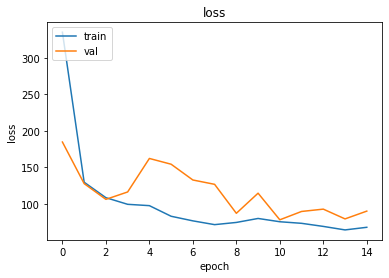

In [ ]:
report.plot_keras_metric("loss")

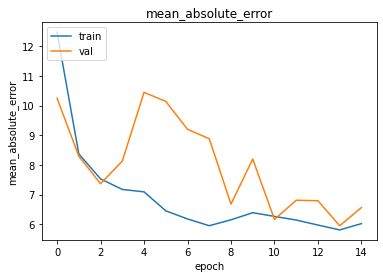

In [ ]:
report.plot_keras_metric("mean_absolute_error")

In [ ]:
report.plot_keras_metric("timedelta")

#### Learning Rate = 0.01

In [ ]:
report = RetentionTimeReport(output_path="./output", history=histories[3])

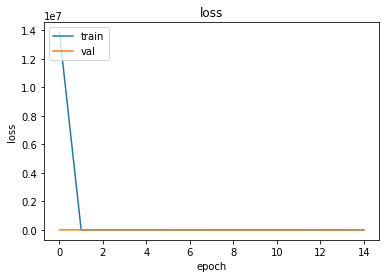

In [ ]:
report.plot_keras_metric("loss")

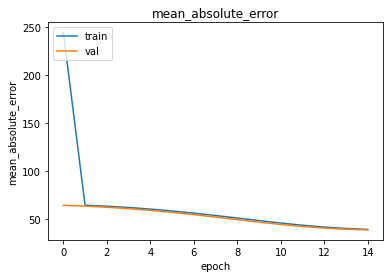

In [ ]:
report.plot_keras_metric("mean_absolute_error")

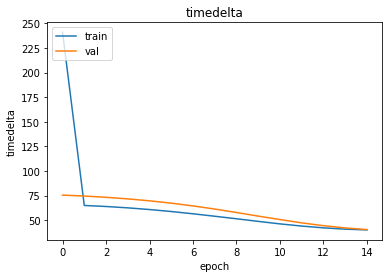

In [ ]:
report.plot_keras_metric("timedelta")

## 4. Conclusion



The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs. But a learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.



#### Learning Rate =0.0001

We can see here that when using lr=0.0001 it doesn't reach the same accuracy as higher learning rates but we can assume that with more training (epochs) it might reach the same loss.


#### Learning Rate = 0.001 vs Learning Rate = 0.01



Here In both cases we reach almost the same accuracy when looking at deltatime or loss but we can see with the higher learning rate of 0.01 the loss fluctuates more in comparison to other learning rate of 0.001 which is one of the drawbacks of using higher learning rates.



#### Learning Rate = 0.1


Here it seems that the model is stuck on a local minima and can't get to improve also we can see fluctuations on the val loss.